# Lab exercise - wave radiation and diffraction
In this notebook we will consider experiments in the wave laboratory, where a ship section will be tested. Two hydrodynamic problems are considered: 
* First, the heave radiation problem will be studied, where the model is forced to perform harmonic oscillations in heave in calm water. The objective of this test is to obtain the hydrodynamic radiation forces (added mass and damping). 
* Second, the diffraction problem will be considered, where the model is fixed and exposed to regular beam sea waves to determine wave excitation force in heave (sum of Froude-Kriloff and diffraction forces).

## Preparations
Preparations prior to lab visit:
When model experiments are planned, it is very important to be well prepared before going to the lab. One should have a clear view of the research questions - what do you seek with the experiments?, what can go wrong?, what do you need to be aware of (precautions)?

## Model and setup
The model is a mid-ship cross-section of a conventional displacement vessel with rounded bilges.

|Parameter   |	Symbol|	Value|	Unit|
|------------|--------|------|------|
|Beam        |	B     |	0.50 |	m   |
|Draft       |	T     |	0.145|	m   |
|Length      |	L     |	0.59 |	m   |
|Bilge radius|	R     |	0.025|	m   |
|Mass        |  M     | 36   | kg   |

<div>
<img src="Figures/model_v2.png" width="300">
</div>

The model is mounted to a vertical actuator on the tank carriage. The model is located in the middle of the tank, at a distance $x_{model}=5.70$ m from the wavemaker. Further, the locations of the wave probes relative to the wavemaker are

|Wave probe | Position |Unit|
|-----------|----------|----|
|WP1        |	3.44   | m  |
|WP2        |	4.52   | m  |
|WP6        |   8.50   | m  |
<div>
<img src="Figures/lab_setup.png" width="700">
</div>

The water-depth in the wavetank should be around 1.0 m, but should be checked before measurements are made. 

In [40]:
import numpy as np

# Model particulars:
rho=1000. # [kg/m^3]
g = 9.81 # [m/s^2]
L = 0.59 # [m]
B = 0.50 # [m]
d = 0.145 # [m]
r = 0.025 # [m]
M = 37.0  # [kg]
Mrigg = 10.3 # [kg]
Depl = rho*L*(B*(d-r)+(B-2*r)*r+np.pi*r**2/2.) # [kg]

# Model position from wavemaker
modelpos = 5.70 # [m]

# Water depth
h = 1.0 # [m]

## Post processing
We start all post-processing of data by loading the data-set and inspecting the data by plotting the raw measurements as time-series. Here we will make use of the python package pandas when working with time-series.

In [32]:

import matplotlib.pyplot as plt
import pandas as pd
import postprocessing as pp

datapath = "../shared/Labdata/2024" # Enter the valid path to your data (copy the data from server to your computer)

radiationtestfile = "extra_radiationtest_f0d83.npz"  # Enter the name of your data-file here..
diffractiontestfile = "extra_diffractiontest.npz"  # Enter the name of your data-file here..

# Import data as pandas DataFrame
df0 = pp.importDataFrame(datapath, radiationtestfile)

# We take a look at the first rows of data. Each measurement signal is stored column-wise
print(df0.head())



   Time  1 - default sample rate  6047 Position  WM_Position  ACC_16476_X  \
0                          0.000  -1.714844e-07    -0.000002    -0.000469   
1                          0.005  -3.429687e-07    -0.000002    -0.001408   
2                          0.010   0.000000e+00    -0.000002    -0.002190   
3                          0.015  -1.714844e-07    -0.000002    -0.002033   
4                          0.020  -1.714844e-07    -0.000001    -0.000860   

   ACC_16476_Y  ACC_16476_Z  FX_20194  FZ_20638       WP1       WP2       WP6  \
0     0.004210    -0.004536 -0.001710 -0.003948  0.000610  0.000320 -0.000045   
1     0.004586    -0.001922 -0.002090 -0.004188  0.000606  0.000318 -0.000046   
2     0.003534    -0.001384 -0.002250 -0.003908  0.000604  0.000286 -0.000049   
3     0.003909    -0.003306 -0.002144 -0.003465  0.000628  0.000252 -0.000035   
4     0.005188    -0.003459 -0.001842 -0.003054  0.000644  0.000260 -0.000023   

         Fx        Fz  
0  0.288345  0.622911  
1 

Looking at the dataframe above, we see that it might be convenient to rename the columns with simpler names. Further, we are informed that the actuator signal "Pos_Rig" is the stroke of the actuator defined positive downwards. We will reverse the sign to consider the vertical (heave) motion of the model, with positive direction upwards.

In [35]:
# Skip columns that we don't need.
df = df0.drop(columns=['FX_20194','FZ_20638'], axis=1) 

# It is convenient to rename the columns with simpler names, e.g. the new names below:
columnnames=df.keys()
newnames=['Time', 'eta3', 'WM_pos', 'accX', 'accY', 'accZ', 'WP1', 'WP2', 'WP6', 'FX', 'FZ']
column_names = dict(zip(df.keys(), newnames))  # This creates a dictionary with {oldname: newname}
df.rename(columns=column_names, inplace=True)

# Reverse the sign to convert actuator stroke to heave motion.
df['eta3'] = -df['eta3']

#Set the column named "Time" as the index. This makes it possible to select data based on time values, instead of using row indices
df.set_index("Time", inplace=True)

# Now let us have a look at the data:
print(df.head())

               eta3    WM_pos      accX      accY      accZ       WP1  \
Time                                                                    
0.000  1.714844e-07 -0.000002 -0.000469  0.004210 -0.004536  0.000610   
0.005  3.429687e-07 -0.000002 -0.001408  0.004586 -0.001922  0.000606   
0.010 -0.000000e+00 -0.000002 -0.002190  0.003534 -0.001384  0.000604   
0.015  1.714844e-07 -0.000002 -0.002033  0.003909 -0.003306  0.000628   
0.020  1.714844e-07 -0.000001 -0.000860  0.005188 -0.003459  0.000644   

            WP2       WP6        FX        FZ  
Time                                           
0.000  0.000320 -0.000045  0.288345  0.622911  
0.005  0.000318 -0.000046  0.351335  0.660653  
0.010  0.000286 -0.000049  0.377427  0.616543  
0.015  0.000252 -0.000035  0.359224  0.546508  
0.020  0.000260 -0.000023  0.308719  0.481779  


### Plotting raw data

Text(0, 0.5, 'Acc. [m/s^2]')

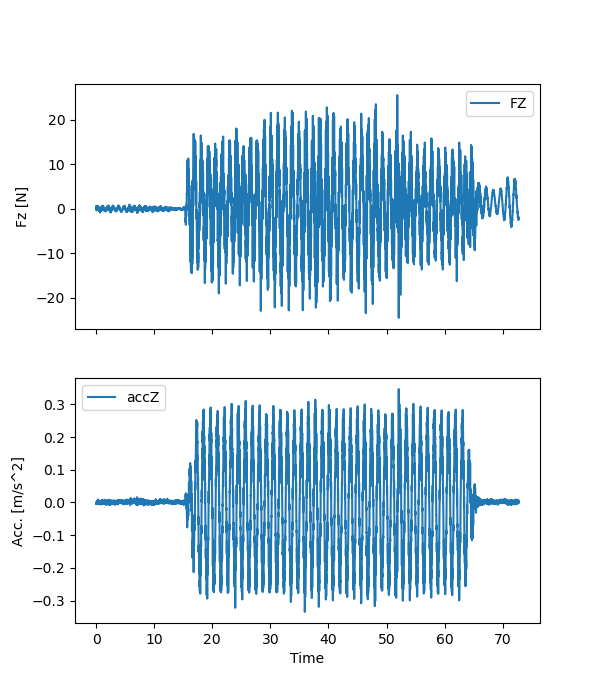

In [37]:
# Example: Plotting of time-series using pandas and matplotlib

# Uncomment the line below if you will activate interactive plotting to allow for zooming etc.
%matplotlib widget
# Uncomment the line below if you will go back to in-line plotting
#%matplotlib inline 

#Looking at the time column, we see that data are sampled every 0.005 s.
#Sampling frequency
dt = 0.005 # [s] time between samples
fs = 1/dt # [Hz] sampling frequency

# Create figure with two subplots (two rows, one column):
fig, ax = plt.subplots(2, 1, figsize=(6, 7), sharex=True) # Create fig handle with two axes
df.plot(ax=ax[0], y='FZ') # the data is plotted against x="Time" which we have set to be the index
ax[0].set_ylabel('Fz [N]')

df.plot(ax=ax[1], y='accZ')
ax[1].set_ylabel('Acc. [m/s^2]')


### Filter data

We see from the figure above that the raw signals contain some noise, in particular the acceleration and force measurements. A common procedure is to filter the data with a *low-pass filter*. This means that we filter away all high frequency components above a given threshold (cut-frequency) and let the low frequency components pass the filter. When defining the cut frequency, we must be sure that we don't remove "physical" frequencies associated with the waves.

In [38]:
# Set cut-frequency and filter the raw data signals (df) using a low-pass filter to remove high frequency noise:
fcut=5 # [Hz] cut frequency (should be larger than the wave frequency fw=1/T [Hz])
df_filtered = pp.filterDataFrame(df, fcut, fs) # New dataframe with filtered data

### Task
* Plot the filtered data signals together with the raw data to compare

### Wave propagation - theory

We need to know when waves generated by the model are reflected back towards the model from the wavemaker, and thus are contaminating our measurements. To estimate the time before wave reflections, we need to know the group velocity, as the wave front propagates with the group velocity. To do this, you need to compute the wavenumber corresponding to the given wave frequency and waterdepth, according to the dispersion relation for finite waterdepth $\omega^2=gk\tanh(kh)$, which is done by the formula *findWaveNumber(wavefrequency, waterdepth)* as shown below.

In [41]:
import airywavelib as aw

# Function to compute wavenumber for a given wave frequency for finite waterdepth:
T = 1.5 # [s] Example wave period
h = 1.0 # [m] Example waterdepth
omega = 2*np.pi/T

# Wave number:
k = aw.findWaveNumber(omega, h)

print("Wavenumber: {:.3} rad/m".format(k))


Wavenumber: 1.87 rad/m


### Task
* Compute the group velocity for finite waterdepth (you can find formula in the compendium) and use this to estimate time to wave reflection.

### Derived time-series
We want to use the measurements to obtain derived quantities, like the inertia force and restoring force. The inertia force in the vertical direction is found as $I_3=M\ddot{\eta}_3$, where $M$ is the models mass and $\ddot{\eta}_3$ is measured heave acceleration. Let us compute the inertia force.

Text(0.5, 1.0, 'Derived time-series')

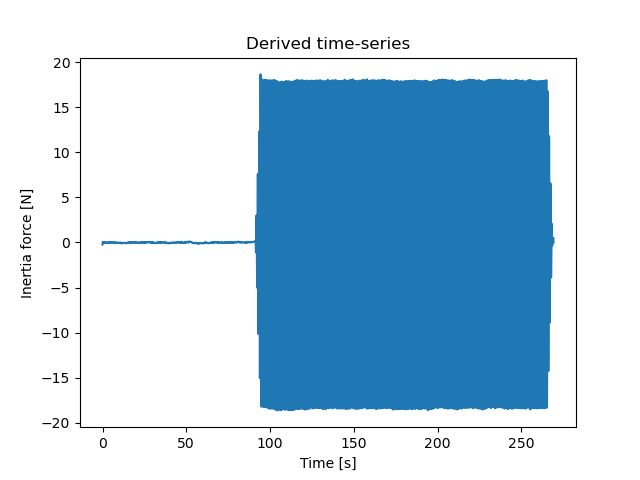

In [17]:
# Inertia force (mass times acceleration):
F_inertia = M*df_filtered['acc3'].values

plt.figure()
plt.plot(df_filtered.index.values, F_inertia)
plt.xlabel('Time [s]')
plt.ylabel('Inertia force [N]')
plt.title("Derived time-series")

### Task
* Compute and plot time-series for the *hydrodynamic force* $F_3^{hd}$ from radiation test by manipulation of the measured force time-signal.
* Compare plot of derived hydrodynamic force (radiation force) with plot of measured (filtered) acceleration. Are the signals in phase?

### Derivation of added mass and damping (voluntary)
From inspection of time-series, we see that the derived hydrodynamic force due to harmonic oscillations is not always 180 degrees out of phase with the heave acceleration. Hence, we can decompose the hydrodynamic force into two components called added mass force and damping force, 180 degrees out of phase with acceleration and velocity in heave, respectively:
$$F_3^{hd}=-A_{33}\ddot{\eta}_3-B_{33}\dot{\eta}_3$$
where $A_{33}$ and $B_{33}$ are added mass and damping coefficient, being (positive) constants depending on the frequency of oscillation.

Utilizing *orthogonal properties* of sine and cosine (the functions $f(x)$ and $g(x)$ are defined to be orthogonal if the integral of their product over some interval is zero, i.e. if $\int f(x)g(x)\mathrm{d}x=0$.) and making the substitution 
$$\dot{\eta}_3(t)=-\omega\eta_{3a}\sin(\omega t)$$
$$\ddot{\eta}_3(t)=-\omega^2\eta_{3a}\cos(\omega t)$$
we can derive the added mass and damping coefficients $A_{33}$ and $B_{33}$.

Added mass is then found by multiplication of the hydrodynamic force by $\cos(\omega t)$ and integrate over $n$ oscillation periods:
$$\int_0^{nT}F_3^{hd}\cos(\omega t)\mathrm{d}t=-A_{33}\int_0^{nT}(-\omega^2 \eta_{3a}\cos(\omega t))\cos(\omega t)\mathrm{d}t - B_{33}\int_0^{nT}(-\omega \eta_{3a}\sin(\omega t))\cos(\omega t)\mathrm{d}t$$
As the force component proportional to $\sin(\omega t)$ becomes zero by integration due to ortogonality, this yields
$$A_{33}=\frac{\int_0^{nT}F_3^{hd}\cos(\omega t)\mathrm{d}t}{\omega\eta_{3a}n\pi}$$
Similarly, damping is found by multiplying the hydrodynamic force by $\sin(\omega t)$, and we obtain
$$\int_0^{nT}F_3^{hd}\sin(\omega t)\mathrm{d}t=-A_{33}\int_0^{nT}(-\omega^2 \eta_{3a}\sin(\omega t))\cos(\omega t)\mathrm{d}t - B_{33}\int_0^{nT}(-\omega \eta_{3a}\sin(\omega t))\sin(\omega t)\mathrm{d}t$$
which leads to
$$B_{33}=\frac{\int_0^{nT}F_3^{hd}\sin(\omega t)\mathrm{d}t}{\eta_{3a}n\pi}$$

In [30]:
import scipy.integrate as si  # We will use the trapeziodal method for numerical integration

fs = 200 # Sampling frequency

# Motion:
eta3a = 0.01 # [m] Heave amplitude
T = 1.5 # [s] Heave oscillation period
nPer = 5 # Number of oscillation periods to be used
omega = 2*np.pi/T

# Define steady state time-window:
t1 = 105 # [s] start of steady state time-interval
delta_t = nPer*T # duration of time-interval as integer number of wave periods

# Steady state time window being an integer number of oscillation periods
timevec = df.loc[t1:(t1+delta_t)].index

# Hydrodynamic force:
Fhd = df_filtered['F3']
# ... Implement expression for the hydrodynamic radiation force here ... Fhd = df_filtered - etc.

# Compute added mass and damping coefficients by integration (trapezoidal integration)
A33 = si.trapz(Fhd.loc[timevec] * np.cos(omega*timevec), x=timevec) / (omega*eta3a*nPer*np.pi)
B33 = si.trapz(Fhd.loc[timevec] * np.sin(omega*timevec), x=timevec) / (eta3a*nPer*np.pi)
print("omega={:.3f} rad/s, A33={:.3f} kg, B33={:.3f} kg/s".format(omega, A33, B33))
print("omega_hat={:.3f} [-], Ca33={:.3f} [-], Cb33={:.3f} [-]".format(omega*np.sqrt(B/(2*g)), A33/M, B33/(M*np.sqrt((2*g)/B))))
#print("omega*delta t: {} [rad]".format(omega*0.25))

omega=4.189 rad/s, A33=-1.261 kg, B33=1.398 kg/s
omega_hat=0.669 [-], Ca33=-0.034 [-], Cb33=0.006 [-]


Text(0, 0.5, '$b_{33}^{2D}$')

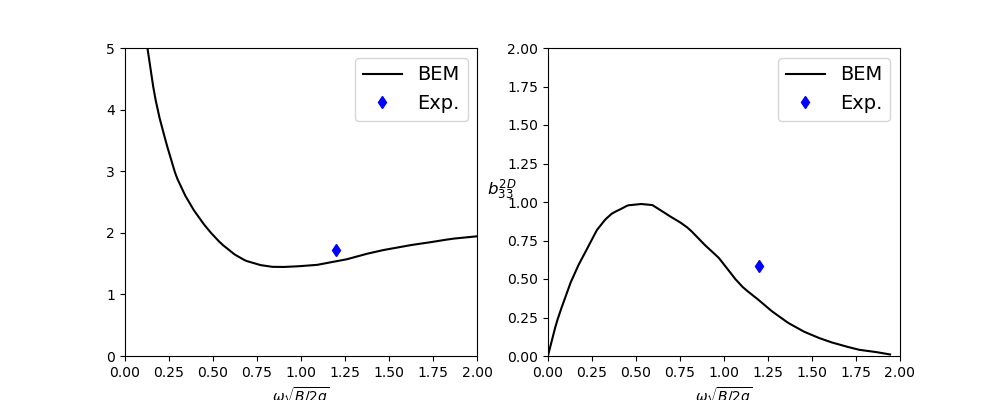

In [21]:
# Import numerical data for comparison (digitized from figure 3-20 in the compendium)
a33data = pd.read_csv("Data/Addedmass_2d_bem.csv", dtype=float, decimal=',')
b33data = pd.read_csv("Data/Damping_2d_bem.csv", dtype=float, decimal=',')

# Verify phase angle
fig2, ax2 = plt.subplots(1, 2, figsize=(10,4))
a33data.plot(ax=ax2[0], x='x', y='a33_Bd2d_2_bem', color='k', label='BEM')
ax2[0].plot(omega*np.sqrt(B/(2*g)), A33/M, 'bd', label='Exp.')
ax2[0].set_ylim(ymin=0., ymax=5.)
ax2[0].set_xlim(xmin=0., xmax=2.)
ax2[0].set_xlabel(r"$\omega\sqrt{B/2g}$")
ax2[1].set_ylabel(r"$a_{33}^{2D}$", rotation=0, fontsize=12)
ax2[0].legend(fontsize=14)

b33data.plot(ax=ax2[1], x='x', y='b33_Bd2d_2_bem', color='k', label='BEM')
ax2[1].plot(omega*np.sqrt(B/(2*g)), B33/(M*np.sqrt((2*g)/B)), 'bd', label='Exp.')
ax2[1].set_ylim(ymin=0, ymax=2.0)
ax2[1].set_xlim(xmin=0, xmax=2.0)
ax2[1].legend(fontsize=14)
ax2[1].set_xlabel(r"$\omega\sqrt{B/2g}$")
ax2[1].set_ylabel(r"$b_{33}^{2D}$", rotation=0, fontsize=12)



## Diffraction problem
Next we consider the diffraction problem, where the model is clamped (restrained from moving) while exposed to beam sea regular waves.
* Plot time-series of measured clamping force and wave elevation from each side of the model.
* Identify steady-state time-window
* How long does it take from start of the wavemaker until you start to measure wave forces on the model (approximately)?

Estimate the Froude-Kriloff force amplitude on the ship section for a range of wave frequencies. The velocity potential for a regular wave on finite water depth according to linear wave theory is
$$\phi(x,z,t)=\frac{g\zeta_a}{\omega}\frac{\cosh(k(z+h))}{\cosh(kh)}\sin(kx-\omega t)$$
You can neglect the rounded bilges in your calculations and consider the model as a box with sharp edges. How does estimated amplitudes agree with measured force amplitudes for the given wave frequency?